# Homework 2: Probe Data Analysis for Road Slope

In [40]:
import time

import numpy as np
import scipy
from scipy import spatial
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import LineModelND, ransac

# autoreload function - so if anything behind the scenes is changeed those changes
# are reflected in the notebook without having to restart the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load and preprocess data

In [2]:
# Functions for loading data

def read_probe_data(filename='Partition6467ProbePoints.csv'):
    # Read probe data
    probe_data_column_names = ['sampleID', 'dateTime', 'sourceCode', 'latitude',\
                            'longitude', 'altitude', 'speed', 'heading']
    df_probe_data = pd.read_csv(filename, names=probe_data_column_names)
    print("Probe data size = {}".format(df_probe_data.shape))

    # Select link data that we are interested in
    indices = ['sampleID', 'latitude', 'longitude', 'altitude']
    df_probe_data = df_probe_data[indices]

    return df_probe_data


def read_link_data(filename='Partition6467LinkData.csv'):
    # Read link data
    link_data_column_names = ['linkPVID', 'refNodeID', 'nrefNodeID', 'length', 'functionalClass', 'directionOfTravel', \
                    'speedCategory', 'fromRefSpeedLimit', 'toRefSpeedLimit', 'fromRefNumLanes', 'toRefNumLanes', \
                    'multiDigitized', 'urban', 'timeZone', 'shapeInfo', 'curvatureInfo', 'slopeInfo']
    df_link_data = pd.read_csv(filename, names=link_data_column_names)

    # Select link data that we are interested in
    indices = ['linkPVID', 'length', 'shapeInfo', 'slopeInfo']
    df_link_data = df_link_data[indices]

    # Preprocess data
    NaN = float('nan')

    def get_coordinate_from_shape_info(df_link_data):
        to_float = lambda num: NaN if not num else float(num)
        # Convert string to number
        shapeInfo = [[] for _ in range(6)]
        for s in df_link_data['shapeInfo']: # s = "51/9/|51/9/"" 
            nums = s.rstrip().replace('|', '/').split('/')
            # lat1, lon1, ele1, lat2, lon2, ele2
            for i in range(6):
                shapeInfo[i].append(to_float(nums[i]))
        
        # Store coordinate values
        for i, name in enumerate(['lat1', 'lon1', 'h1', 'lat2', 'lon2', 'h2']):
            df_link_data[name] = shapeInfo[i] # Insert new columns
        df_link_data.drop(columns =["shapeInfo"], inplace=True) # Delete "shapeInfo" column
        return df_link_data
    df_link_data = get_coordinate_from_shape_info(df_link_data)

    def get_slope_from_slope_info(df_link_data):
        slopeInfo = []
        for ith_data, s in enumerate(df_link_data['slopeInfo']):
            slopeInfo.append([])
            if type(s) is str:
                str_nums = s.rstrip().replace('|', '/').split('/')
                nums = list(map(float, str_nums))
                for i in range(len(str_nums)//2):
                    dist, angle = nums[i*2], nums[i*2+1]
                    slopeInfo[-1].append((dist, angle))
        df_link_data["slopeInfo"] = slopeInfo
        return df_link_data
    df_link_data = get_slope_from_slope_info(df_link_data)
        

    # Drop bad data
    cols_to_check = ["lat1", "lon1", "lat2", "lon2"]
    for col_name in cols_to_check:
        df_link_data = df_link_data[pd.notna(df_link_data[col_name])]

    # Print link data
    print("Link data size: {}".format(df_link_data.shape))

    return df_link_data


In [3]:
# Read probe data
df_probe_data = read_probe_data(filename='Partition6467ProbePoints.csv')

DEBUG = False
if DEBUG: # select a subset of probes
    df_probe = df_probe_data[df_probe_data['sampleID']==3496]
else:
    df_probe = df_probe_data

print("Select {} probe data for road matching.".format(len(df_probe)))
df_probe.head(10)

Probe data size = (3375745, 8)
Select 3375745 probe data for road matching.


,sampleID,latitude,longitude,altitude
0,3496,51.496868,9.386022,200
1,3496,51.496682,9.386157,200
2,3496,51.496705,9.386422,201
3,3496,51.496749,9.386840,201
4,3496,51.496864,9.387294,199
5,3496,51.496930,9.387716,198
6,3496,51.496957,9.387794,198
7,3496,51.496952,9.387805,197
8,3496,51.496949,9.387818,196
9,3496,51.496944,9.387840,196


In [4]:
# Read link data
df_link_data = read_link_data(filename='Partition6467LinkData.csv')
df_link_data.head(10)

Link data size: (200089, 9)


,linkPVID,length,slopeInfo,lat1,lon1,h1,lat2,lon2,h2
0,62007637,335.04,[],51.49658,9.38623,NaN,51.499470,9.384880,NaN
1,567329767,134.56,[],51.49658,9.38623,NaN,51.496690,9.386710,NaN
2,62007648,97.01,[],51.49629,9.38491,NaN,51.496580,9.386230,NaN
3,78670326,314.84,[],51.49629,9.38491,NaN,51.499000,9.383610,NaN
4,51881672,110.17,"[(0.0, -0.09), (110.17, 0.062)]",53.06431,8.79034,45.79,53.065030,8.791470,45.74
5,51881767,212.54,"[(0.0, 0.062), (111.93, 0.17), (212.54, 0.081)]",53.06503,8.79147,45.74,53.065746,8.792644,46.01
6,51881768,186.28,"[(0.0, 0.081), (186.28, -0.114)]",53.06639,8.79370,46.25,53.067630,8.795570,46.13
7,51881825,140.13,"[(0.0, -0.114), (140.13, -0.12)]",53.06763,8.79557,46.13,53.068550,8.797000,45.83
8,51881938,85.54,"[(0.0, -0.12), (42.93, 0.162), (85.54, 0.328)]",53.06855,8.79700,45.83,53.068821,8.797457,45.85
9,811768915,59.45,"[(0.0, 0.228), (29.82, 0.076), (59.45, 0.222)]",53.06909,8.79791,46.04,53.069200,8.798316,46.10


In [5]:
# Functions for converting (latitude, longitude) into (x, y) coordinates

def get_average_latitude_and_longtidue(df_link_data):
    lat_mean = df_link_data[["lat1"]].mean().values[0]
    lon_mean = df_link_data[["lon1"]].mean().values[0]
    print("lat_mean = {}, lon_mean = {} ".format(lat_mean, lon_mean))
    return lat_mean/180*np.pi, lon_mean/180*np.pi

def convert_lat_lon_to_x_y(df_data, lat_name, lon_name, x_name, y_name, lat_mean, lon_mean):
    
    R = 6371*1000
    alpha, beta = lon_mean, lat_mean
    
    def sphere_to_world_coordinate(lat, lon):
        alpha, beta = lon, lat
        return R * np.array([
            np.cos(beta)*np.cos(alpha),
            np.cos(beta)*np.sin(alpha),
            np.sin(beta)
        ])

    OL = sphere_to_world_coordinate(lat_mean, lon_mean)
    XL = np.array([-np.sin(alpha), np.cos(alpha), 0])
    YL = np.cross(OL, XL) / np.linalg.norm(OL)
    
    lats = df_data[lat_name]/180*np.pi
    lons = df_data[lon_name]/180*np.pi
    OPs = sphere_to_world_coordinate(lats, lons)
    cartisian_coordinates = np.vstack((XL, YL))
    x_y_pos = np.dot(cartisian_coordinates, OPs - OL[:, np.newaxis]).T
    
    # Store x, y positions into pandas
    df_data.loc[:, x_name] = x_y_pos[:, 0]
    df_data.loc[:, y_name] = x_y_pos[:, 1]

In [6]:
# Convert probe and link's position from (latitude, longitude) to (x, y) coordinate

# Compute average lat and lon. A new coordinate will be established here.
lat_mean, lon_mean = get_average_latitude_and_longtidue(df_link_data)

# Convert probe
convert_lat_lon_to_x_y(
    df_probe, lat_name='latitude', lon_name='longitude',
    x_name='x', y_name='y', lat_mean=lat_mean, lon_mean=lon_mean)

# Convert link
convert_lat_lon_to_x_y(df_link_data, 'lat1', 'lon1', 'x1', 'y1', lat_mean, lon_mean)
convert_lat_lon_to_x_y(df_link_data, 'lat2', 'lon2', 'x2', 'y2', lat_mean, lon_mean)

lat_mean = 52.02835310710885, lon_mean = 9.672628234304732 


In [7]:
df_probe.head(5)

,sampleID,latitude,longitude,altitude,x,y
0,3496,51.496868,9.386022,200,-19840.282600,-59058.457363
1,3496,51.496682,9.386157,200,-19831.015987,-59079.174802
2,3496,51.496705,9.386422,201,-19812.659142,-59076.730743
3,3496,51.496749,9.386840,201,-19783.726800,-59071.905033
4,3496,51.496864,9.387294,199,-19752.245865,-59059.279069


In [8]:
df_link_data.head(5)

,linkPVID,length,slopeInfo,lat1,lon1,h1,lat2,lon2,h2,x1,y1,x2,y2
0,62007637,335.04,[],51.49658,9.38623,NaN,51.49947,9.38488,NaN,-19826.032184,-59090.560713,-19918.222656,-58768.854519
1,567329767,134.56,[],51.49658,9.38623,NaN,51.49669,9.38671,NaN,-19826.032184,-59090.560713,-19792.749635,-59078.471863
2,62007648,97.01,[],51.49629,9.38491,NaN,51.49658,9.38623,NaN,-19917.528756,-59122.455848,-19826.032184,-59090.560713
3,78670326,314.84,[],51.49629,9.38491,NaN,51.49900,9.38361,NaN,-19917.528756,-59122.455848,-20006.338873,-58820.764686
4,51881672,110.17,"[(0.0, -0.09), (110.17, 0.062)]",53.06431,8.79034,45.79,53.06503,8.79147,45.74,-58951.340283,115544.679531,-58874.859563,115623.804869


# Find links near probe data

In [9]:
# Find links near probe data
# (Later we will build a kdtree to further speed up the road matching.)

def filt_data_by_range(df_data, bbox, dist_threshold):
    xmin, ymin, xmax, ymax = bbox
    c1 = df_data["x1"] <= xmax + dist_threshold
    c2 = df_data["x1"] >= xmin - dist_threshold
    c3 = df_data["y1"] <= ymax + dist_threshold
    c4 = df_data["y1"] >= ymin - dist_threshold
    c5 = df_data["x2"] <= xmax + dist_threshold
    c6 = df_data["x2"] >= xmin - dist_threshold
    c7 = df_data["y2"] <= ymax + dist_threshold
    c8 = df_data["y2"] >= ymin - dist_threshold
    return df_data.loc[c1 & c2 & c3 & c4 & c5 & c6 & c7 & c8, :]

# Find the bounding box of the probe data
x, y = df_probe["x"], df_probe["y"]
bbox =  (x.min(), y.min(), x.max(), y.max())

# Get links that are near the probe data
df_link = filt_data_by_range(df_link_data, bbox, dist_threshold=1000)


# Print
print("Link data size: {}".format(200089, 9))
df_link.head(5)

Link data size: 200089


,linkPVID,length,slopeInfo,lat1,lon1,h1,lat2,lon2,h2,x1,y1,x2,y2
0,62007637,335.04,[],51.49658,9.38623,NaN,51.49947,9.38488,NaN,-19826.032184,-59090.560713,-19918.222656,-58768.854519
1,567329767,134.56,[],51.49658,9.38623,NaN,51.49669,9.38671,NaN,-19826.032184,-59090.560713,-19792.749635,-59078.471863
2,62007648,97.01,[],51.49629,9.38491,NaN,51.49658,9.38623,NaN,-19917.528756,-59122.455848,-19826.032184,-59090.560713
3,78670326,314.84,[],51.49629,9.38491,NaN,51.49900,9.38361,NaN,-19917.528756,-59122.455848,-20006.338873,-58820.764686
4,51881672,110.17,"[(0.0, -0.09), (110.17, 0.062)]",53.06431,8.79034,45.79,53.06503,8.79147,45.74,-58951.340283,115544.679531,-58874.859563,115623.804869


# Convert probe and link data to Python class objects

In [10]:
# Convert probe and link to object (took 10 minutes)

import time
t0 = time.time()

class Probe(object):
    def __init__(self, ID, x, y, h):
        self.ID, self.x, self.y, self.h = ID, x, y, h
        return
    
    def __str__(self):
        return "Node: id = {:<6}, x = {:<10.1f}, y = {:<10.1f}, h = {:<10.1f}".format(
            self.ID, self.x, self.y, self.h)
    
class Link(object):
    def __init__(self, ID, x1, y1, x2, y2, slopeInfo):
        self.ID = ID
        self.x1, self.y1 = x1, y1
        self.x2, self.y2 = x2, y2
        if len(slopeInfo) == 0:
            self.slope = np.float('nan')
        else:
            slopes = [sl[1] for sl in slopeInfo]
            self.slope = sum(slopes) / len(slopes) # Choose the mean slope
        
        self.neighbor_probes = []
        return
    
    def __str__(self):
        return ("Link: id = {:<10}, x1 = {:<10.1f}, y1 = {:<10.1f}, " + 
                "x2 = {:<10.1f}, y2 = {:<10.1f}, slope = {:<6.3f}"
               ).format(self.ID, self.x1, self.y1, self.x2, self.y2, self.slope)

probes = [Probe(ID=int(p["sampleID"]), x=p["x"], y=p["y"], h=p["altitude"])
            for _, p in df_probe.iterrows()]

print("After {:.1f} seconds, converting probes completes.".format(time.time() - t0))

links = [Link(ID=int(p["linkPVID"]), x1=p["x1"], y1=p["y1"], x2=p["x2"], y2=p["y2"], slopeInfo=p["slopeInfo"])
            for _, p in df_link.iterrows()]

print("After {:.1f} seconds, converting links completes.".format(time.time() - t0))


for i in range(10):
    print(probes[i])
for i in range(10):
    print(links[i])

After 232.6 seconds, converting probes completes.
After 256.6 seconds, converting links completes.
Node: id = 3496  , x = -19840.3  , y = -59058.5  , h = 200.0     
Node: id = 3496  , x = -19831.0  , y = -59079.2  , h = 200.0     
Node: id = 3496  , x = -19812.7  , y = -59076.7  , h = 201.0     
Node: id = 3496  , x = -19783.7  , y = -59071.9  , h = 201.0     
Node: id = 3496  , x = -19752.2  , y = -59059.3  , h = 199.0     
Node: id = 3496  , x = -19723.0  , y = -59052.0  , h = 198.0     
Node: id = 3496  , x = -19717.6  , y = -59049.0  , h = 198.0     
Node: id = 3496  , x = -19716.8  , y = -59049.6  , h = 197.0     
Node: id = 3496  , x = -19715.9  , y = -59050.0  , h = 196.0     
Node: id = 3496  , x = -19714.4  , y = -59050.5  , h = 196.0     
Link: id = 62007637  , x1 = -19826.0  , y1 = -59090.6  , x2 = -19918.2  , y2 = -58768.9  , slope = nan   
Link: id = 567329767 , x1 = -19826.0  , y1 = -59090.6  , x2 = -19792.7  , y2 = -59078.5  , slope = nan   
Link: id = 62007648  , x1 = -

# Build K-d Tree

In [14]:
# Build a kd-tree for the links, so we can use O(log(N)) time to search the nearest links of a probe.
# The "key" for each link is its center. (The center is not 
#   an accurate distance measure to the probe. 
#   we will need to query multiple neighbor links and measure the distances again.)

class KDTreeLinks(object):
    def __init__(self, links):
        link_center_positions = [ self.get_center(link) for link in links]
        self.kdtree = spatial.KDTree(link_center_positions)
        self.links = links
        
    def get_center(self, link):
        x_center = (link.x1 + link.x2) / 2
        y_center = (link.y1 + link.y2) / 2
        return (x_center, y_center)
    
    def query(self, probe, num_neighbors=1, DEBUG=False):
        point = [probe.x, probe.y]
        dists, indices = self.kdtree.query(point, k=num_neighbors)
        links = [self.links[ind] for ind in indices]
        if DEBUG: # Print result
            link_IDs = [self.links[ind].ID for ind in indices]
            print("\nTest probe: {}".format(probe))
            print("  It's neighbor links:")
            for link in links:
                print("    ", link)
        return links
    
kdtree = KDTreeLinks(links)
print("Build tree completes.")
kdtree.query(probes[0], num_neighbors=5, DEBUG=True)
print("Test completes")

Build tree completes.

Test probe: Node: id = 3496  , x = -19840.3  , y = -59058.5  , h = 200.0     
  It's neighbor links:
     Link: id = 567329767 , x1 = -19826.0  , y1 = -59090.6  , x2 = -19792.7  , y2 = -59078.5  , slope = nan   
     Link: id = 62007648  , x1 = -19917.5  , y1 = -59122.5  , x2 = -19826.0  , y2 = -59090.6  , slope = nan   
     Link: id = 62007637  , x1 = -19826.0  , y1 = -59090.6  , x2 = -19918.2  , y2 = -58768.9  , slope = nan   
     Link: id = 78670326  , x1 = -19917.5  , y1 = -59122.5  , x2 = -20006.3  , y2 = -58820.8  , slope = nan   
     Link: id = 62006493  , x1 = -19852.7  , y1 = -59359.5  , x2 = -19881.4  , y2 = -59256.0  , slope = nan   
Test completes


# Geometry Algebra

In [74]:
def calc_dist_to_line_segment(x, y, x1, y1, x2, y2):
    # reference:
    # https://stackoverflow.com/questions/849211/shortest-distance-between-a-point-and-a-line-segment
    A, B, C, D = x - x1, y - y1, x2 - x1, y2 - y1
    dot = A * C + B * D
    len_sq = C * C + D * D
    param = -1
    if len_sq != 0:  # in case of 0 length line
        param = dot / len_sq
    if param < 0:
        xx = x1
        yy = y1
    elif param > 1:
        xx = x2
        yy = y2
    else:
        xx = x1 + param * C
        yy = y1 + param * D
    intersect_point = (xx, yy)
    return ((x - xx)**2 + (y - yy)**2)**0.5, intersect_point

def calc_dist(probe, link):
    dist, intersect_point = calc_dist_to_line_segment(
        probe.x, probe.y, link.x1, link.y1, link.x2, link.y2)
    return dist, intersect_point

def fit_line(x, y, z):
    # Fit a line to a set of points (xi, yi, zi)
    # Input: three np.array
    # reference:
    # https://stackoverflow.com/questions/2298390/fitting-a-line-in-3d
    data = np.vstack((x, y, z)).T
    datamean = data.mean(axis=0)
    uu, dd, vv = np.linalg.svd(data - datamean)  # do SVD
    line_direction_vector = vv[0] # vv[0] is the 1st principal vector
    return line_direction_vector, datamean

def fit_line_ransac(xyz): # Use sklearn library
    model_robust, inliers = ransac(xyz, LineModelND, min_samples=2,
                               residual_threshold=1, max_trials=1000)
    line_direction_vector = model_robust.params[1]
    datamean = model_robust.params[0]
    return line_direction_vector, datamean

# Road matching

In [63]:
# Match roads (~ 25 minutes)
# Find the nearest links of each probe

NUM_NEIGHBORS = 10 # An approximate number of neighbor links, that might contain the nearest link.
DIST_THRESHOLD = 50 # A link is considered good only when the distance is smaller than this threshold
RATIO_THRESHOLD = 0.5 # (1st_min_dist / 2st_min_dist) < Threshold, then the link is good

t0 = time.time()

def reset_links(links):
    for link in links:
        link.neighbor_probes = []
        link.data_to_fit_slope = []
reset_links(links)

cnt_success_match = 0
for ith_probe, probe in enumerate(probes):

    if ith_probe % 200000 == 0:
        print("Processing: {}/{}, time cost = {}s".format(
            ith_probe, len(probes), time.time() - t0))
        
    # Find nearest link
    neighbor_links = kdtree.query(probe, num_neighbors=NUM_NEIGHBORS)
    dists = [calc_dist(probe, link)[0] for link in neighbor_links]
    idx = dists.index(min(dists))
    nearest_link = neighbor_links[idx]
    
    # Restore the distance and position of the probe
    dist, intersect_point = calc_dist(probe, nearest_link)
    if 0: # Use intersection point position
        x, y = intersect_point[0], intersect_point[1]
    else: # Use probe's raw x, y position
        x, y = probe.x, probe.y
        
    # Check result
    if dist >= DIST_THRESHOLD:
        continue
        
    dists.sort()
    if (dists[0] / dists[1]) >= RATIO_THRESHOLD:
        continue
    
    # Check if distance is good
    # Store is
    nearest_link.neighbor_probes.append(probe)
    nearest_link.data_to_fit_slope.append([x, y, probe.h])
    cnt_success_match += 1

print("Time cost = {}s".format(time.time() - t0))
print("Total probes = {}. Matched probes = {}".format(
    len(probes), cnt_success_match))

Processing: 0/3375745, time cost = 0.5484552383422852s
Processing: 200000/3375745, time cost = 77.1257631778717s
Processing: 400000/3375745, time cost = 153.4239342212677s
Processing: 600000/3375745, time cost = 229.01509547233582s
Processing: 800000/3375745, time cost = 305.364643573761s
Processing: 1000000/3375745, time cost = 382.3231301307678s
Processing: 1200000/3375745, time cost = 459.3016128540039s
Processing: 1400000/3375745, time cost = 536.4886603355408s
Processing: 1600000/3375745, time cost = 614.3279583454132s
Processing: 1800000/3375745, time cost = 692.2489678859711s
Processing: 2000000/3375745, time cost = 769.9279162883759s
Processing: 2200000/3375745, time cost = 847.4995238780975s
Processing: 2400000/3375745, time cost = 924.880921125412s
Processing: 2600000/3375745, time cost = 999.920574426651s
Processing: 2800000/3375745, time cost = 1077.6882202625275s
Processing: 3000000/3375745, time cost = 1154.6858477592468s
Processing: 3200000/3375745, time cost = 1231.9995

# Compute slopes

In [77]:
# Compute slopes
# We have project each probe onto the nearest link.
# Now, for each link, fit a line to its probes, and compute slope

t0 = time.time()

slope_results = [] # store [link_ID, link.slope, esimated_slope]
for ith_link, link in enumerate(links):
    
    if False and ith_link % 100 == 0:
        print("Processing: {}/{}, time cost = {}s".format(
            ith_link, len(links), time.time() - t0))
        
    data = np.array(link.data_to_fit_slope)
    num_points = data.shape[0]
    
    if num_points < 3:
        line_vec = float('nan')
        esimated_slope = np.float('nan')
    else:
        line_vec, _ = fit_line(x=data[:, 0], y=data[:, 1], z=data[:, 2])
        # line_vec, _ = fit_line_ransac(data)
        esimated_slope = np.arctan(line_vec[2] / np.sqrt(line_vec[0]**2 + line_vec[1]**2))/np.pi*180
        if True and abs(esimated_slope) > 5: # set a threshold here
            esimated_slope = np.float('nan')
            
    if ith_link < 10:
        # print("\n\nProbes: [x, y, height]:\n", data)
        print("True slope = {:<6.3f}, esimated slope = {:<6.3f}. Line vec = {}".format(
            link.slope, esimated_slope, line_vec))
    slope_results.append([link.ID, link.slope, esimated_slope])
    
print("Time cost = {:.1f}s".format(time.time() - t0))

True slope = nan   , esimated slope = 0.000 . Line vec = [ 0.44684762 -0.89461008  0.        ]
True slope = nan   , esimated slope = 1.033 . Line vec = [-0.96260068 -0.27032322  0.01803564]
True slope = nan   , esimated slope = nan   . Line vec = [-0.95809987 -0.26873706  0.09912131]
True slope = nan   , esimated slope = 0.996 . Line vec = [-0.3024309   0.95301272  0.0173871 ]
True slope = -0.014, esimated slope = nan   . Line vec = [ 0.69153208  0.71400837 -0.10943226]
True slope = 0.104 , esimated slope = 2.778 . Line vec = [0.70533677 0.70721378 0.04846344]
True slope = -0.017, esimated slope = -0.557. Line vec = [-0.68438526 -0.72905586 -0.00971461]
True slope = -0.117, esimated slope = 3.862 . Line vec = [0.66678587 0.74219916 0.06735734]
True slope = 0.123 , esimated slope = nan   . Line vec = [ 0.25302994  0.50872154 -0.82290841]
True slope = 0.175 , esimated slope = nan   . Line vec = [-0.23288322 -0.06670532 -0.97021431]
Time cost = 9.7s


In [78]:
# Write result to file
filename = "slope_results.csv"
np.savetxt(filename, slope_results) # link ID, true slope, estimated slope

In [79]:
# Load result from file
if 1:
    filename = "slope_results.csv"
    slope_results = np.loadtxt(filename) # link ID, true slope, estimated slope
link_slopes = slope_results[:, 1]
estimated_slope = slope_results[:, 2]

# Analyze result

In [80]:
N = link_slopes.size
num_valid_slope_true = np.count_nonzero(~np.isnan(link_slopes))
num_valid_slope_esti = np.count_nonzero(~np.isnan(estimated_slope))

valid_indices = (~np.isnan(link_slopes)) & (~np.isnan(estimated_slope))
num_valid_slope_both = np.count_nonzero(valid_indices)

print("Total links = {}".format(N))
print("Number of valid ground truth slope data = {}".format(num_valid_slope_true))
print("Number of valid estimated slope data = {}".format(num_valid_slope_esti))
print("The intersection of the above two data = {}".format(num_valid_slope_both))

slope_true = link_slopes[valid_indices]
slope_esti = estimated_slope[valid_indices]

Total links = 200089
Number of valid ground truth slope data = 53517
Number of valid estimated slope data = 56964
The intersection of the above two data = 20005


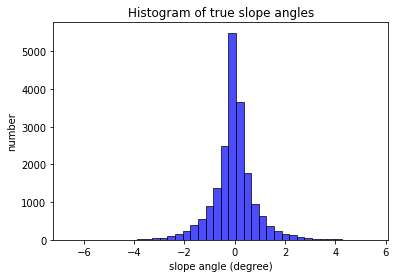

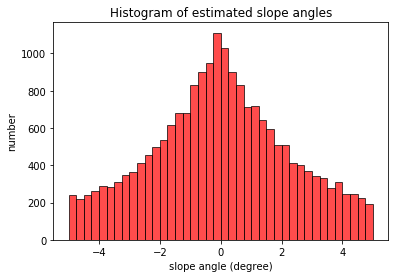

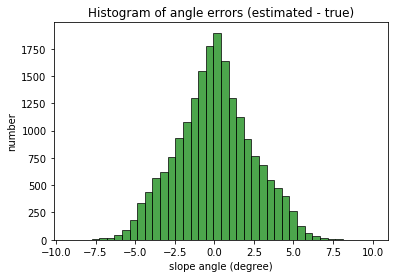

In [81]:
# Plot historgram of true slopes
plt.hist(slope_true, bins=40, normed=0, facecolor="blue", edgecolor="black", alpha=0.7, label='True')
plt.xlabel("slope angle (degree)")
plt.ylabel("number")
plt.title("Histogram of true slope angles")
plt.show()

# Plot historgram of estimated slopes
plt.hist(slope_esti, bins=40, normed=0, facecolor="red", edgecolor="black", alpha=0.7, label='Estimated')
plt.xlabel("slope angle (degree)")
plt.ylabel("number")
plt.title("Histogram of estimated slope angles")
plt.show()

# Plot historgram of error slopes
plt.hist(slope_esti-slope_true, bins=40, normed=0, facecolor="green", edgecolor="black", alpha=0.7, label='Estimated')
plt.xlabel("slope angle (degree)")
plt.ylabel("number")
plt.title("Histogram of angle errors (estimated - true)")
plt.show()

# Plot map of a choose probe

In [82]:
# Before plotting data, let's see what probe indices are there:
probe_IDs = sorted(list(set([probe.ID for probe in probes])))
print("Show some probe IDs:", probe_IDs[0:5])

Show some probe IDs: [3496, 4552, 4553, 4554, 4555]


186 probes to plot
186 links  to plot


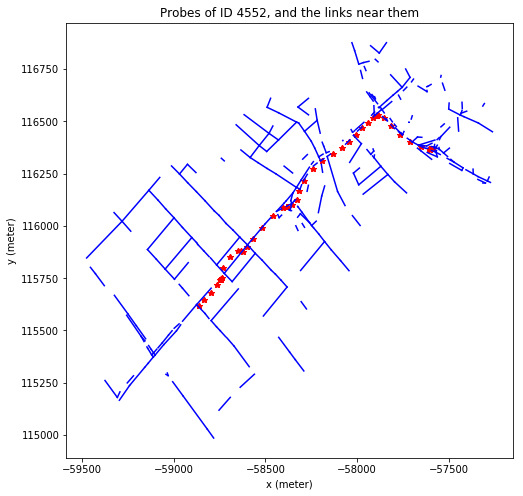

In [85]:
# Plot map

def plot_probes_and_links(probe_ID):
    plot_probes = []
    plot_links = {}

    plot_probes = [probe for probe in probes if probe.ID == probe_ID_for_plot]
    for probe in plot_probes:
        neighbor_links = kdtree.query(probe, num_neighbors=100)
        for link in neighbor_links:
            plot_links[link.ID] = link

    print("{} probes to plot".format(len(plot_probes)))
    print("{} links  to plot".format(len(plot_probes)))

    # Plot probe
    fig = plt.figure(figsize=(8, 8))
    probe_xys = [(probe.x, probe.y) for probe in plot_probes]
    probe_xs, probe_ys = zip(*probe_xys)
    plt.plot(probe_xs, probe_ys, 'r*')

    # Plot links
    links_xxyy = [(link.x1, link.x2, link.y1, link.y2) for link in plot_links.values()] 
    links_x1, links_x2, links_y1, links_y2 = zip(*links_xxyy)
    plt.plot([links_x1, links_x2], [links_y1, links_y2], 'b-')

    # Add label
    plt.xlabel('x (meter)')
    plt.ylabel('y (meter)')
    plt.title('Probes of ID {}, and the links near them'.format(probe_ID_for_plot))
    plt.show()
    
probe_ID_for_plot = 4552
plot_probes_and_links(probe_ID_for_plot)